# Generative Adversarial Network
...

## Implementation
This implementation of Deep Convolutional GAN is trained on MNIST Dataset.

**Dimensions** 
- `b` : batch size
- `im` : image size = (28, 28)
- `h` : latent vector size
### imports

In [11]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
from torchvision.utils import save_image, make_grid

from tqdm import tqdm
import matplotlib.pyplot as plt
import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Data Preperation (Dataset, DataLoader)

In [5]:
train_data = MNIST('./data', train=True, transform=transforms.ToTensor(), download=True)
test_data = MNIST('./data', train=False, transform=transforms.ToTensor(), download=True)

trainloader = DataLoader(train_data, batch_size=128, shuffle=True)
testloader = DataLoader(test_data, batch_size=128)

### Model
#### Generator
input|<span style="font-weight:normal">random Latent vector `(torch.tensor: (b, h))`</span>
|:-------:|:---------------------------------------------------------------------------------|
**output**| Generated Image `(torch.tensor: (b, *im))`

`Generator` generates images from random noise input.

- `nn.ConvTransposed2d`: Transposed Convolution is usually used for upscaling images.

In [6]:
class Generator(nn.Module):
    def __init__(self, lat_dim=64):
        super(Generator, self).__init__()
        self.input_size = 7
        self.stage1 = nn.Linear(lat_dim, 128*self.input_size**2)
        self.stage2 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 1, 4, 2, 1),
            nn.Tanh(),
        )
        
    def forward(self, x):
        x = self.stage1(x)
        x = x.view(x.shape[0], 128, self.input_size, self.input_size)
        x = self.stage2(x)
        return x

#### Discriminator
input|<span style="font-weight:normal">Image `(torch.tensor: (b, *im))`</span>
|:-------:|:---------------------------------------------------------------------------------|
**output**| Discrimination result `(torch.tensor: (b,))`

`Discriminator` trys to identify if the input image is real or generated.

- We use Factory pattern for convolution module delcaration as `disc_module`(abrev. of discriminator module)

In [7]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        def disc_module(in_ch, out_ch):
            return [
                nn.Conv2d(in_ch, out_ch, 3, 2, 1, bias=False),
                nn.BatchNorm2d(out_ch),
                nn.LeakyReLU(0.2, inplace=True),
            ]
            
        self.disc_model = nn.Sequential(
            *disc_module(1, 512),
            *disc_module(512, 256),
            *disc_module(256, 128),
            nn.AvgPool2d(4),
        )
        
        self.fc = nn.Sequential(
            nn.Linear(128, 1),
            nn.Sigmoid(),
        )
        
    def forward(self, x):
        x = self.disc_model(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x

#### Declare model

In [8]:
lat_dim = 64
G = Generator(lat_dim).to(device)
D = Discriminator().to(device)

### Training
#### Optimizers
Since Generator and Discriminator needs to be trained seperately(has different objectives), we define their optimizers seperately.
- `opt_G` : optimizes parameters of `Generator`
- `opt_D` : optimizes parameters of `Discriminator`

In [9]:
opt_G = optim.Adam(G.parameters(), lr=0.01, betas=(0.5, 0.999))
opt_D = optim.Adam(D.parameters(), lr=0.01, betas=(0.5, 0.999))

#### Train setup

In [10]:
loss_fn = nn.BCELoss()
epochs = 10 # try 150

#### Training loop
1. Generate Fake Images 
    - generate random noise `z : (b, h)`
    - generate fake images(`gen_image=G(z)`)
<br /><br />
2. Declare True/False Labels
    - For comparing results from `Discriminator` output, it is nessasary to declare true/false lable as `[1]*b` and `[0]*b`.
    - `trues  : torch.ones(b, 1)`
    - `falses : torch.zeros(b, 1)`
<br /><br />
3. Train `Generator` : Generate needs to trick Discriminator to think fake images are real.
    - Use optimizer `opt_G` for training only the parameters of `G`.

        |$\min_{G} BCE($`D(G(`$z$`))`$,$`trues`$)$ |<span style="font-weight:normal">`D(gen_image)` should be close to 1 (fake images labeled as real images)</span>|
        |----------------------------------|----------------------------------------------------------------------------------------------------------------|
<br />

4. Train `Discriminator` : Discreminator needs to identify real and fake images.
    - Use optimizer `opt_D` for training only the parameters of `D`.    
    
        |$\min_{D} BCE($`D(`$img_{real}$`)`$,$`trues`$)$ |<span style="font-weight:normal">`D(gen_image)` should be close to 1 (fake images labeled as real images)</span>|
        |------------------------------------|----------------------------------------------------------------------------------------------------------------|
        |**$\min_{D} BCE($`D(`$img_{fake}$`)`$,$`falses`$)$**|`D(gen_image)` should be close to 0 (fake images labeled as fake images)|

In [12]:
for epoch in range(epochs):
    for idx, (image, _) in enumerate(tqdm(trainloader, desc=f'epoch {epoch+1}/{epochs}')):
        batch = image.shape[0]
        
        # true and false labels with batch_size
        trues = torch.ones(batch, 1).to(device)
        falses = torch.zeros(batch, 1).to(device)
        
        # real images
        real_image = image.type(torch.FloatTensor).to(device)
        
        # gen images
        z = torch.randn((batch, lat_dim)).to(device) # random latent
        gen_image = G(z)
        
        # generator training
        loss_G = loss_fn(D(gen_image), trues)
        
        opt_G.zero_grad()
        loss_G.backward()
        opt_G.step()
        
        # discriminator training
        real_image_loss = loss_fn(D(real_image), trues)
        fake_image_loss = loss_fn(D(gen_image.detach()), falses)
        
        loss_D = (real_image_loss + fake_image_loss) / 2
        
        opt_D.zero_grad()
        loss_D.backward()
        opt_D.step()
    
    # uncomment to save generated images in each epochs
    '''
    save_image(
        gen_image[:100],
        f"images_mnist/gan_out_{epoch+1}.png",
        nrow=10,
        normalize=True
    )
    '''

epoch 10/10: 100%|██████████| 469/469 [00:24<00:00, 19.30it/s]


#### Generated Image Samples

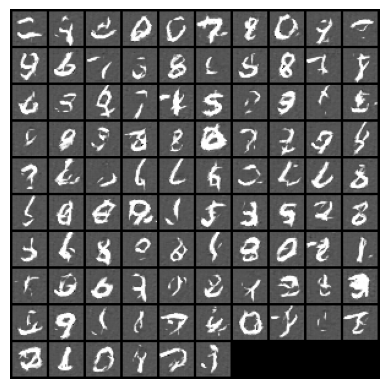

In [17]:
plt.axis('off')
plt.imshow(make_grid(gen_image[:100].detach().cpu(), nrow=10, normalize=True).permute((1, 2, 0)))